In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.linalg import eigh
from scipy.linalg import eig

In [2]:
class locality_linear_projections(object):
    def __init__(self, n_components = 2, n_neighbours = 5, weight = 'adjacency', weight_width = 1, neighbours_algorithm = 'auto'):
        
        """
        Locality Preserving Projection 
        
        Write up the stuff later
        """
        
        self.n_components = n_components #
        self.n_neighbours = n_neighbours #number of neighbours to keep
        self.weight = weight #How to calculate weights
        self.weight_width = weight_width #Float
        self.neighbours_algorithm = neighbours_algorithm #string ['auto'|'brute'|'kd_tree'|'ball_tree']
    
    def _construct_adjacency_graph(self, X):
        
        if self.weight == 'adjacency':
            
            self._nbrs_obj = kneighbors_graph(X, 
                                              self.n_neighbours,
                                              mode='connectivity', 
                                              include_self=True)

        elif self.weight == 'heat':
            
            self._nbrs_obj = kneighbors_graph(X, 
                                              self.n_neighbours,
                                              mode='distance', 
                                              include_self=True)
            
            self._nbrs_obj.data = np.exp(-self._nbrs_obj.data ** 2 / self.weight_width ** 2)
        
        else:
            print("Illegal graph construction.")
            raise SystemExit
        
        #Convert to matrix
        self.non_symm_adjacency = self._nbrs_obj.toarray()
    
    def _construct_laplacian(self):
        
        #Make the adjacency matrix symmetric
        self.W = np.maximum(self.non_symm_adjacency, self.non_symm_adjacency.T)
        self.D = np.diag(np.sum(self.W, axis = 1))
        self.L = self.D - self.W
    
    def _compute_projection(self, X):
        
        #Since X^T D X is always symmetric, we can use np.linalg.eigh
        
        A = np.dot(X.T, np.dot(self.L, X))
        B = np.dot(X.T, np.dot(self.D, X))
        
        evals, evec = self.eigh_robust(A, B, eigvals=(0, self.n_components - 1))
        #self.eigh_robust(A, B, eigvals=(0, self.n_components - 1))
        #eigh(A, B, subset_by_index=[0, self.n_components - 1])
        
        self.evals = evals
        self.projection = evec
        
    
    def fit(self, X):
        
        self._construct_adjacency_graph(X)
        self._construct_laplacian()
        self._compute_projection(X)
        
        return self
    
    def fit_transform(self, X):
        
        self.fit(X)
        Z = self.transform(X)
        
        return Z
    
    def transform(self, X):
            
        Z = np.dot(X, self.projection)
        
        return Z
    
    #copied from online source... not sure why eigh fails but this one works.
    def eigh_robust(self, a, b=None, eigvals = None, eigvals_only=False,
                overwrite_a=False, overwrite_b=False,
                turbo=True, check_finite=True):
        """Robustly solve the Hermitian generalized eigenvalue problem
        This function robustly solves the Hermetian generalized eigenvalue problem
        ``A v = lambda B v`` in the case that B is not strictly positive definite.
        When B is strictly positive-definite, the result is equivalent to
        scipy.linalg.eigh() within floating-point accuracy.
        Parameters
        ----------
        a : (M, M) array_like
            A complex Hermitian or real symmetric matrix whose eigenvalues and
            eigenvectors will be computed.
        b : (M, M) array_like, optional
            A complex Hermitian or real symmetric matrix.
            If omitted, identity matrix is assumed.
        eigvals : tuple (lo, hi), optional
            Indexes of the smallest and largest (in ascending order) eigenvalues
            and corresponding eigenvectors to be returned: 0 <= lo <= hi <= M-1.
            If omitted, all eigenvalues and eigenvectors are returned.
        eigvals_only : bool, optional
            Whether to calculate only eigenvalues and no eigenvectors.
            (Default: both are calculated)
        turbo : bool, optional
            Use divide and conquer algorithm (faster but expensive in memory,
            only for generalized eigenvalue problem and if eigvals=None)
        overwrite_a : bool, optional
            Whether to overwrite data in `a` (may improve performance)
        overwrite_b : bool, optional
            Whether to overwrite data in `b` (may improve performance)
        check_finite : bool, optional
            Whether to check that the input matrices contain only finite numbers.
            Disabling may give a performance gain, but may result in problems
            (crashes, non-termination) if the inputs do contain infinities or NaNs.
        Returns
        -------
        w : (N,) float ndarray
            The N (1<=N<=M) selected eigenvalues, in ascending order, each
            repeated according to its multiplicity.
        v : (M, N) complex ndarray
            (if eigvals_only == False)
        """
        kwargs = dict(eigvals=eigvals, eigvals_only=eigvals_only,
                      turbo=turbo, check_finite=check_finite,
                      overwrite_a=overwrite_a, overwrite_b=overwrite_b)

        # Check for easy case first:
        if b is None:
            return linalg.eigh(a, **kwargs)

        # Compute eigendecomposition of b
        kwargs_b = dict(turbo=turbo, check_finite=check_finite,
                        overwrite_a=overwrite_b)  # b is a for this operation
        S, U = linalg.eigh(b, **kwargs_b)

        # Combine a and b on left hand side via decomposition of b
        S[S <= 0] = np.inf
        Sinv = 1. / np.sqrt(S)
        W = Sinv[:, None] * np.dot(U.T, np.dot(a, U)) * Sinv
        output = linalg.eigh(W, **kwargs)

        if eigvals_only:
            return output
        else:
            evals, evecs = output
            return evals, np.dot(U, Sinv[:, None] * evecs)

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(1000, n_features=300, centers=4,
                  cluster_std=8, random_state=42)

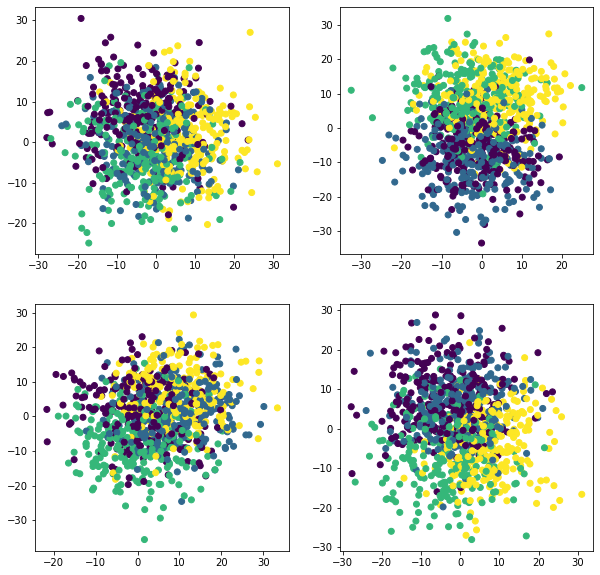

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
rand = np.random.RandomState(42)

for axi in ax.flat:
    i, j = rand.randint(X.shape[1], size=2)
    axi.scatter(X[:, i], X[:, j], c=y)

In [5]:
lpp1 = locality_linear_projections(n_components = 2, weight = 'adjacency', weight_width = 0.1)
X_2D = lpp1.fit_transform(X)

print(X_2D.shape)
plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y)
plt.show()

NameError: name 'linalg' is not defined

In [ ]:
lpp2 = LocalityPreservingProjection(n_components=2, weight = 'adjacency', weight_width = 0.1)
X_2D = lpp2.fit_transform(X)
print(X_2D.shape)
plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y)
plt.title("Projected from 300->2 dimensions")
plt.show()